In [33]:
import scanpy as sc
adata = sc.read_h5ad('single_cell_after_QC.h5ad')

/home/nastya/.local/lib/python3.9/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/nastya/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [28]:
adata

AnnData object with n_obs × n_vars = 98656 × 21973
    obs: 'sample', 'UMI_count', 'gene_count', 'unmatched_rate', 'doublet_score', 'somite_number', 'embryo_sex', 'development_stage', 'celltype', 'removed_by_low_quality_or_doublets', 'RT_group'
    var: 'gene_id', 'gene_type', 'gene_short_name', 'chr', 'start', 'end', 'strand'

In [ ]:
import scanpy as sc
import anndata as ad
import pandas as pd

adata = ad.AnnData(
    X=adata.X,
    obs=pd.DataFrame(adata.obs['somite_number']),
    var=pd.DataFrame(index=adata.var_names)
)
adata_Epcam = adata[adata[:, 'Epcam'].X > 0].copy()
adata_Epcam.var_names_make_unique
adata_Epcam.write('Epcam_dataset_filtered.h5ad')

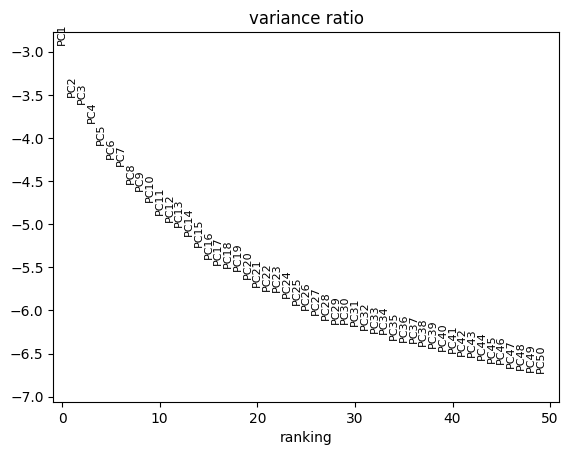

In [295]:
sc.pl.pca_variance_ratio(adata_Epcam, n_pcs=50, log=True)


In [7]:
adata_Epcam

AnnData object with n_obs × n_vars = 2948 × 5000
    obs: 'somite_number', 'cell_type', 'leiden'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'somite_number_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [50]:
#Preprocessing

import scanpy as sc
import numpy as np

# 1. Preprocess
sc.pp.normalize_total(adata_Epcam, target_sum=1e4)
sc.pp.log1p(adata_Epcam)

adata_Epcam.raw = adata_Epcam.copy()

sc.pp.highly_variable_genes(adata_Epcam, n_top_genes=5000)
adata_Epcam = adata_Epcam[:, adata_Epcam.var['highly_variable']]

sc.pp.scale(adata_Epcam)
sc.tl.pca(adata_Epcam, svd_solver='arpack')

/home/nastya/.local/lib/python3.9/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


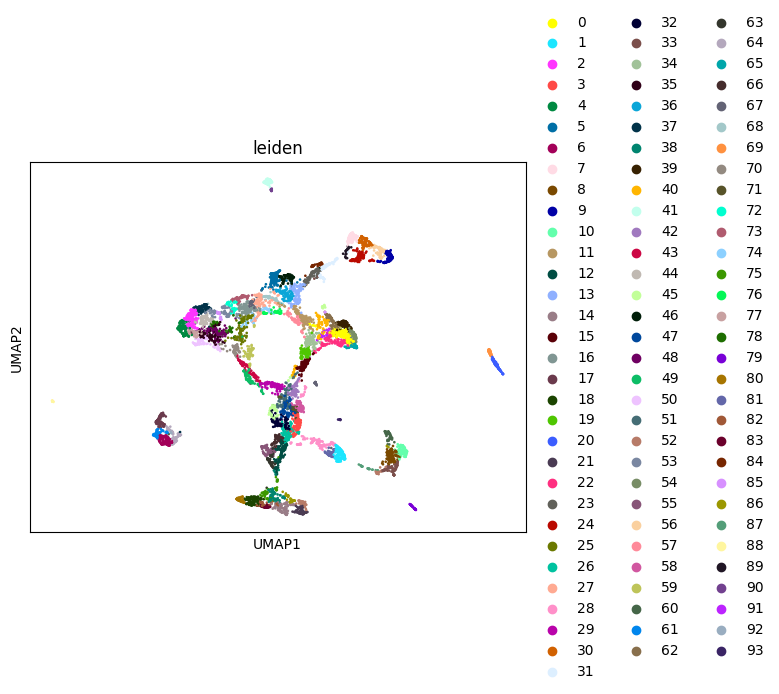

In [51]:
sc.pp.neighbors(adata_Epcam, n_neighbors=10, n_pcs=15, random_state=42)
sc.tl.umap(adata_Epcam, random_state=42, min_dist=0.1)

sc.tl.leiden(adata_Epcam, resolution=5, random_state=42)

sc.pl.umap(adata_Epcam, color=['leiden'])

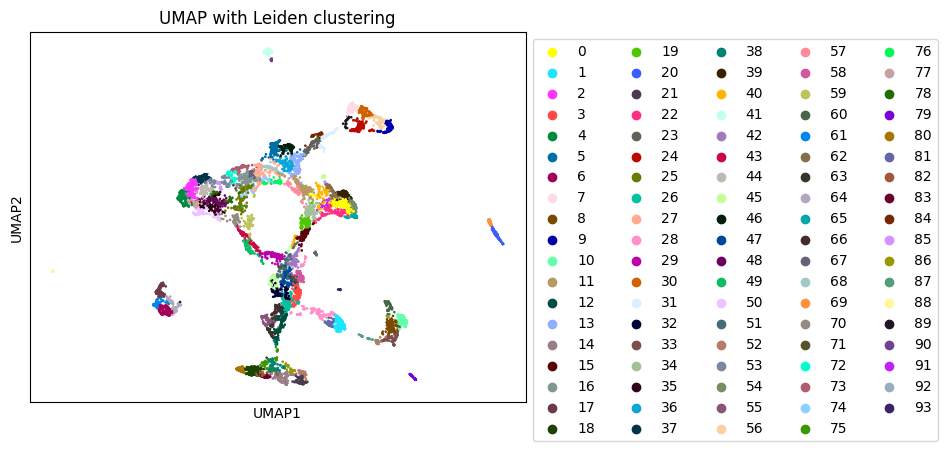

In [22]:
fig = sc.pl.umap(adata_Epcam, color='leiden', show=False, return_fig=True)

# Modify legend and title
plt.legend(ncol=5, bbox_to_anchor=(1, 1), loc='upper left')
plt.title('UMAP with Leiden clustering')

# Save figure
fig.savefig('umapleiden.png', bbox_inches='tight', dpi=300)
plt.show()


In [3]:
import scanpy as sc
adata_Epcam = sc.read_h5ad('single_cell_res5_pc15.h5ad')


In [2]:
g = adata_Epcam.obs['leiden']           
counts = g.value_counts().sort_index()
props  = counts / counts.sum()

print(counts)                           
print(props.round(3))                  

imbalance_ratio = counts.max() / counts.min()     
cv = counts.std(ddof=0) / counts.mean()           

import numpy as np
p = props.values
norm_entropy = -(p * np.log(p+1e-12)).sum() / np.log(len(p))   

print(f"Imbalance ratio (max/min): {imbalance_ratio:.2f}")
print(f"Coefficient of variation:  {cv:.2f}")
print(f"Normalized entropy (0-1):  {norm_entropy:.2f}")
print(f"Smallest cluster size:     {counts.min()} cells")


0     90
1     81
2     70
3     68
4     68
      ..
62    17
63    13
64    11
65    11
66     7
Name: leiden, Length: 67, dtype: int64
0     0.031
1     0.027
2     0.024
3     0.023
4     0.023
      ...  
62    0.006
63    0.004
64    0.004
65    0.004
66    0.002
Name: leiden, Length: 67, dtype: float64
Imbalance ratio (max/min): 12.86
Coefficient of variation:  0.39
Normalized entropy (0-1):  0.98
Smallest cluster size:     7 cells


In [333]:
adata_Epcam.write('single_cell_res5_pc15.h5ad')

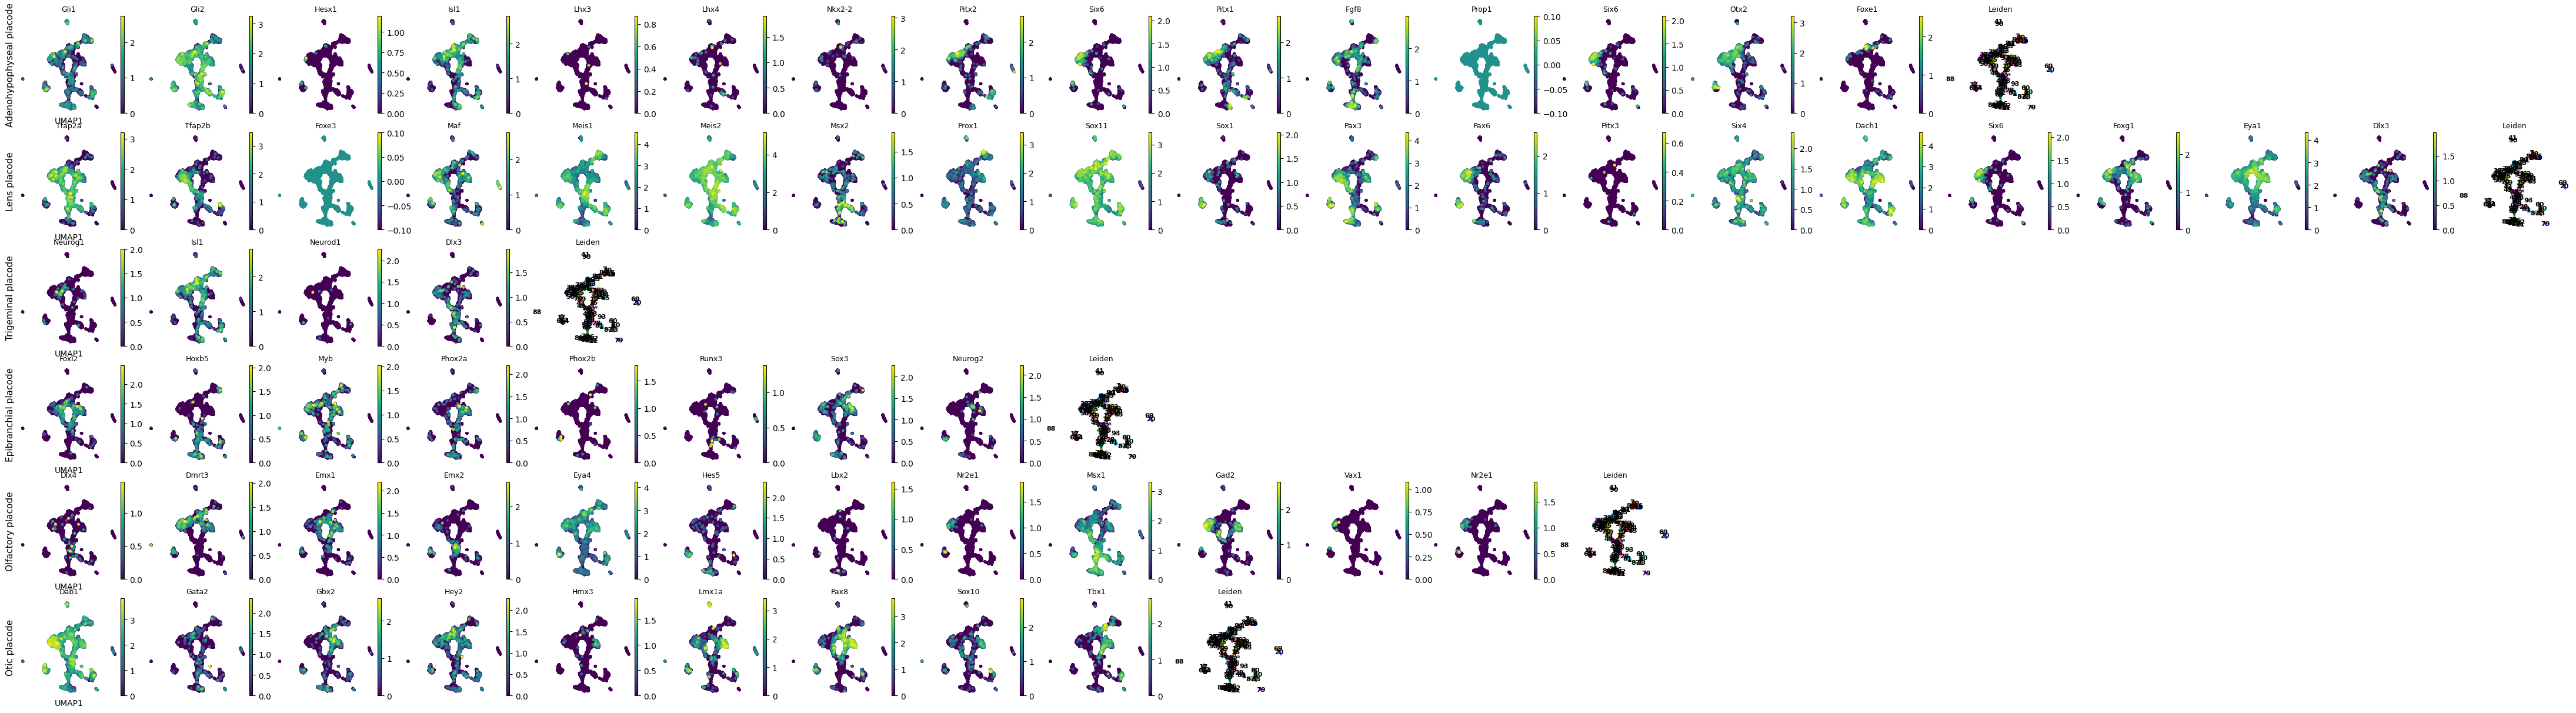

In [27]:
#Lets check markers 

import matplotlib.pyplot as plt
import random
import scanpy as sc

placodes = {
    "Adenohypophyseal placode": [
        "Gli1", "Gli2", "Hesx1", "Isl1",
        "Lhx3", "Lhx4", "Nkx2-2", "Pitx2", "Six6", "Pitx1", "Fgf8", "Prop1", "Six6", "Otx2", 'Foxe1'
    ],
    "Lens placode": [
        "Tfap2a", "Tfap2b", "Foxe3", "Maf", "Meis1",
        "Meis2", "Msx2", "Prox1", "Sox11",
        "Sox1", "Pax3", "Pax6", "Pitx3", "Six4", "Dach1", "Six6", "Foxg1", "Eya1", "Dlx3"
    ],
    "Trigeminal placode": [
        "Neurog1", "Isl1",
        "Neurod1", "Dlx3"
    ],
    "Epibranchial placode": [
        "Foxi2", "Hoxb5", "Myb",
        "Phox2a", "Phox2b", "Runx3", "Sox3", 'Neurog2'
    ],
    "Olfactory placode": [
        "Dlx4", "Dmrt3", "Emx1", "Emx2", "Eya4", "Hes5",
        "Lbx2", "Nr2e1", "Msx1", "Gad2", "Vax1", "Nr2e1"
    ],
    "Otic placode": [
        "Dab1", "Gata2", "Gbx2", "Hey2",
        "Hmx3", "Lmx1a",
        "Pax8", "Sox10", "Tbx1"
    ]
}



random.seed(42)

nrow = len(placodes)
ncol = max(len(vs) for vs in placodes.values()) + 1

# Smaller per-panel size to reduce spacing
fig, axs = plt.subplots(nrow, ncol, figsize=(2.8 * ncol, 2.5 * nrow))

if nrow == 1:
    axs = [axs]

for row_idx, (cell_type, markers) in enumerate(placodes.items()):
    col_idx = 0
    for marker in markers:
        ax = axs[row_idx][col_idx]
        sc.pl.umap(
            adata_Epcam,
            color=marker,
            ax=ax,
            show=False,
            frameon=False,
            size=50
        )
        ax.set_title(marker, fontsize=9)

        if col_idx == 0:
            ax.axis("on")
            ax.tick_params(
                top=False, bottom=False,
                left=False, right=False,
                labelleft=True, labelbottom=False
            )
            ax.set_ylabel(cell_type, rotation=90, fontsize=11)
            ax.set(frame_on=False)

        col_idx += 1

    # Leiden plot at end
    ax_leiden = axs[row_idx][col_idx]
    sc.pl.umap(
        adata_Epcam,
        color='leiden',
        ax=ax_leiden,
        show=False,
        frameon=False,
        size=20,
        legend_loc='on data',
        legend_fontsize=8
    )
    ax_leiden.set_title("Leiden", fontsize=9)

    col_idx += 1
    while col_idx < ncol:
        axs[row_idx][col_idx].remove()
        col_idx += 1

# Tighter spacing
plt.subplots_adjust(wspace=0.15, hspace=0.2)  # horizontal and vertical space between plots




In [42]:
#filtered according to UMAP 

placode_markers = {
    "Adenohypophyseal placode": [
        "Hesx1", "Isl1",
        "Nkx2-2", "Pitx2", "Lhx4", "Six6", "Otx2", "Pitx1", 'Foxe1'
    ],
    "Lens placode": [
        "Tfap2b", "Maf", 
        "Pax3", "Pax6", "Six6", "Foxg1", "Eya1", "Dlx3"
    ],
    "Trigeminal placode": [
        "Neurog1", "Isl1", "Pax3", "Fgfr4"
    ],
    "Epibranchial placode": [
        "Foxi2", "Hoxb5", "Myb",
        "Phox2a", "Sox3", 'Neurog2'
    ],
    "Olfactory placode": [
        "Dmrt3", "Hes5",
        "Nr2e1", "Gad2", "Vax1", "Nr2e1", "Foxg1"
    ],
    "Otic placode": [
        "Gbx2", "Hey2", "Gata2",
        "Hmx3", "Lmx1a",
        "Pax8", "Sox10", "Tbx1"
    ]
}


In [ ]:
sc.tl.rank_genes_groups(
    adata_Epcam, groupby='leiden', method='t-test', use_raw=adata_Epcam.raw)

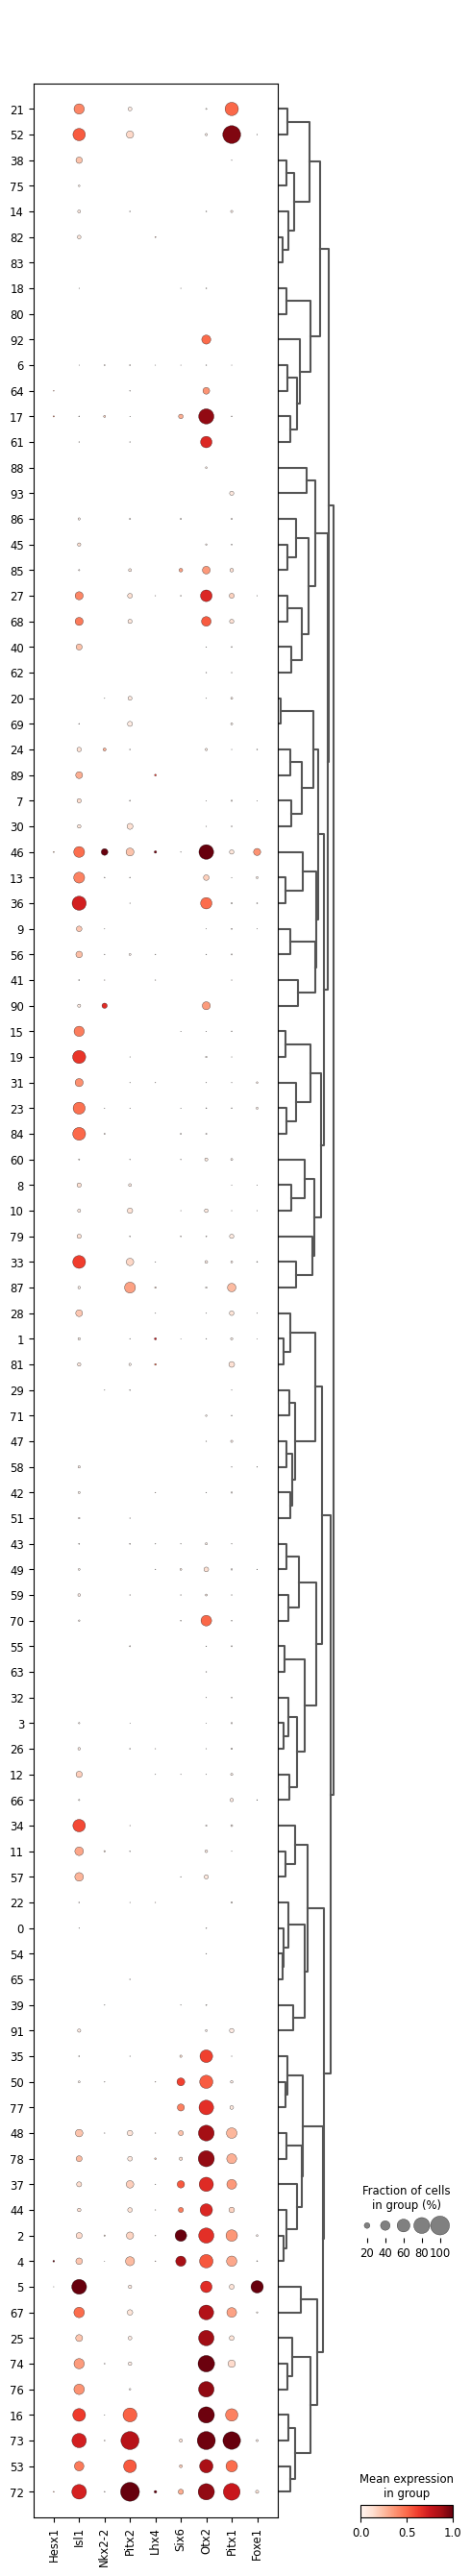

In [29]:
# Adenohypophyseal placode = 46, 5
sc.pl.rank_genes_groups_dotplot(
    adata_Epcam, groupby='leiden', standard_scale="var", var_names=placode_markers["Adenohypophyseal placode"])


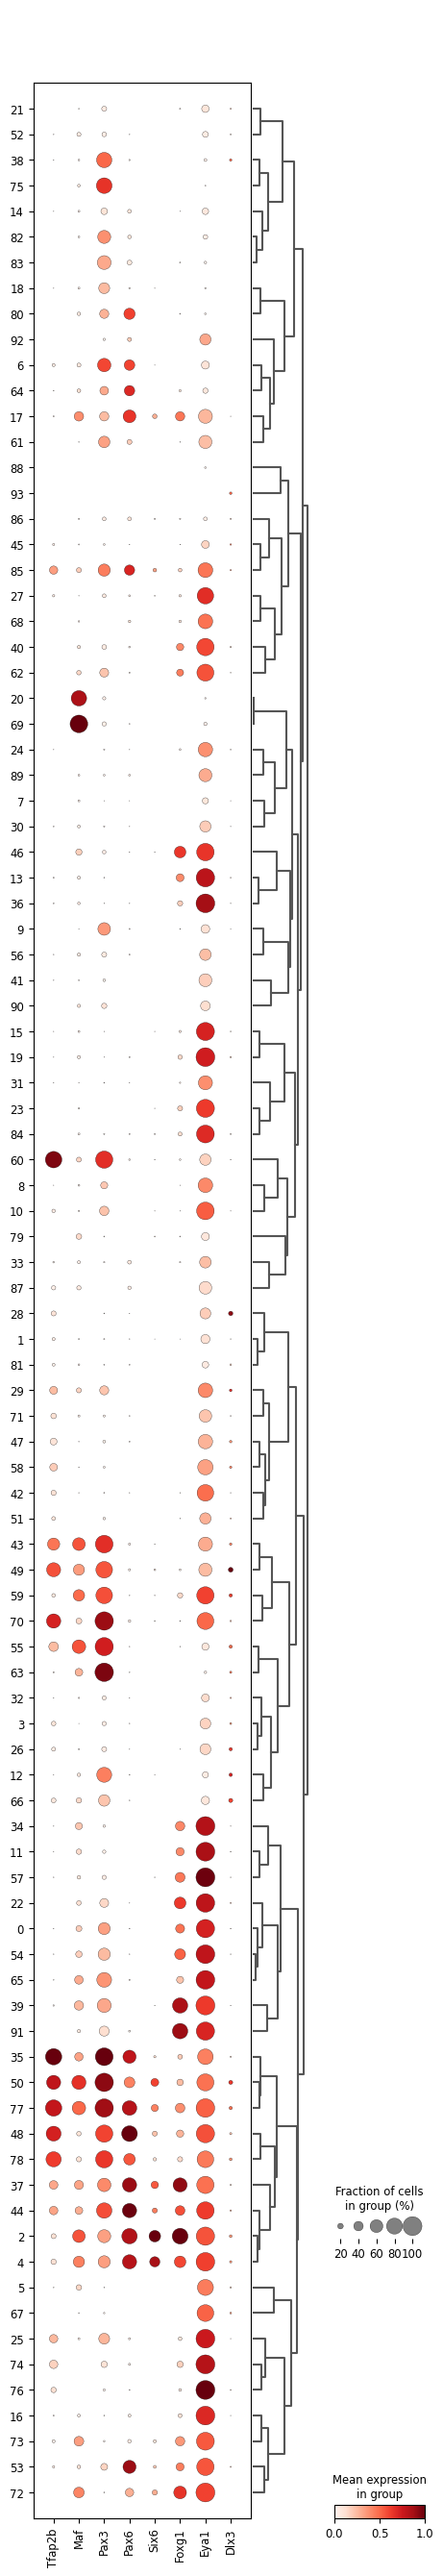

In [38]:
#Lens placode = '35', '50', '70'
sc.pl.rank_genes_groups_dotplot(
    adata_Epcam, groupby='leiden', standard_scale="var", var_names=placode_markers["Lens placode"])


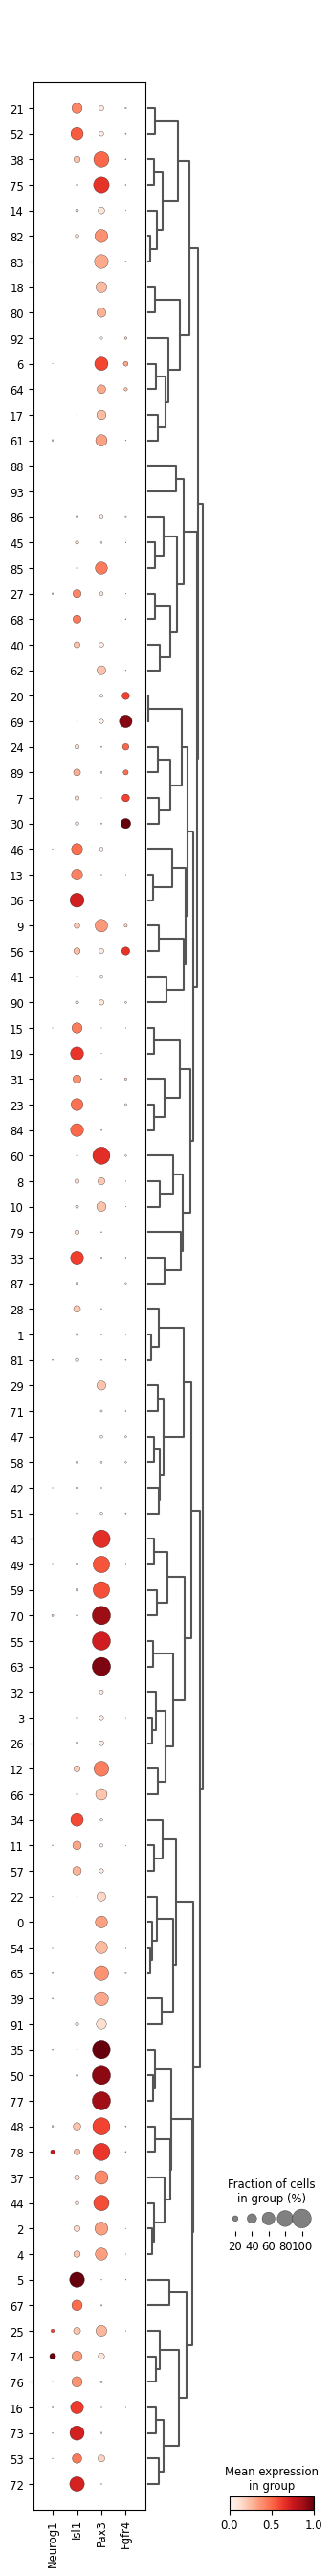

In [82]:
# Trigeminal placode = 25 + 74
sc.pl.rank_genes_groups_dotplot(
    adata_Epcam, groupby='leiden', standard_scale="var", var_names=placode_markers["Trigeminal placode"])


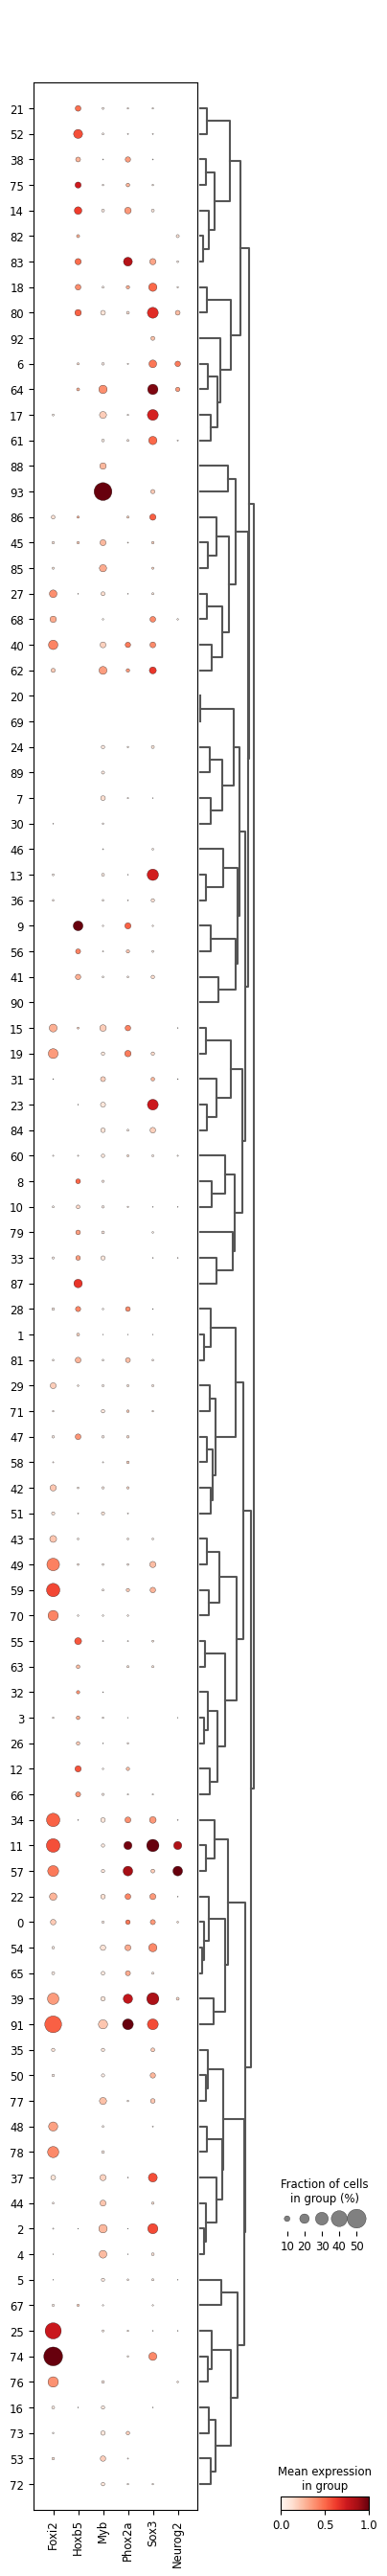

In [13]:
# 'Epibranchial placode' = 39 + 91
sc.pl.rank_genes_groups_dotplot(
    adata_Epcam, groupby='leiden', standard_scale="var", var_names=placode_markers['Epibranchial placode'])


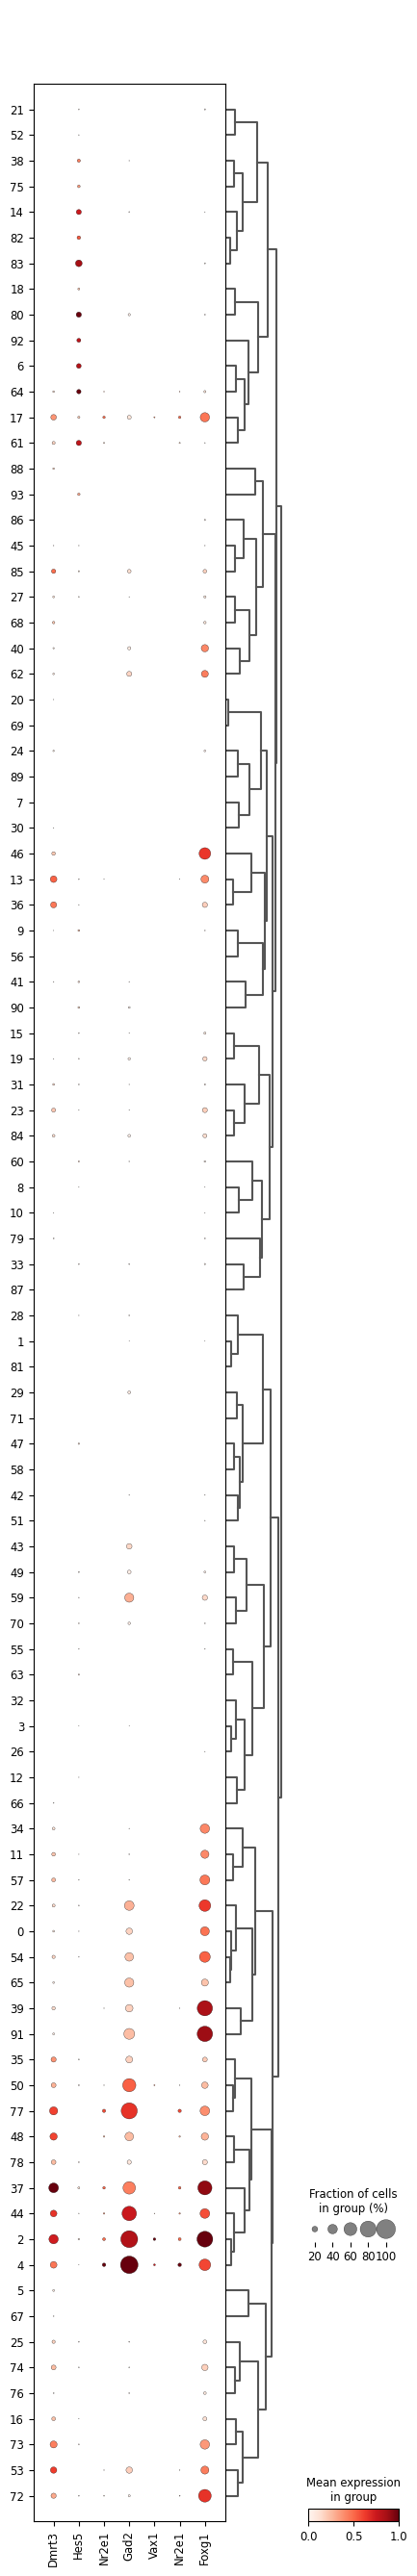

In [43]:
# '2', '4', '37'
sc.pl.rank_genes_groups_dotplot(
    adata_Epcam, groupby='leiden', standard_scale="var", var_names=placode_markers["Olfactory placode"])


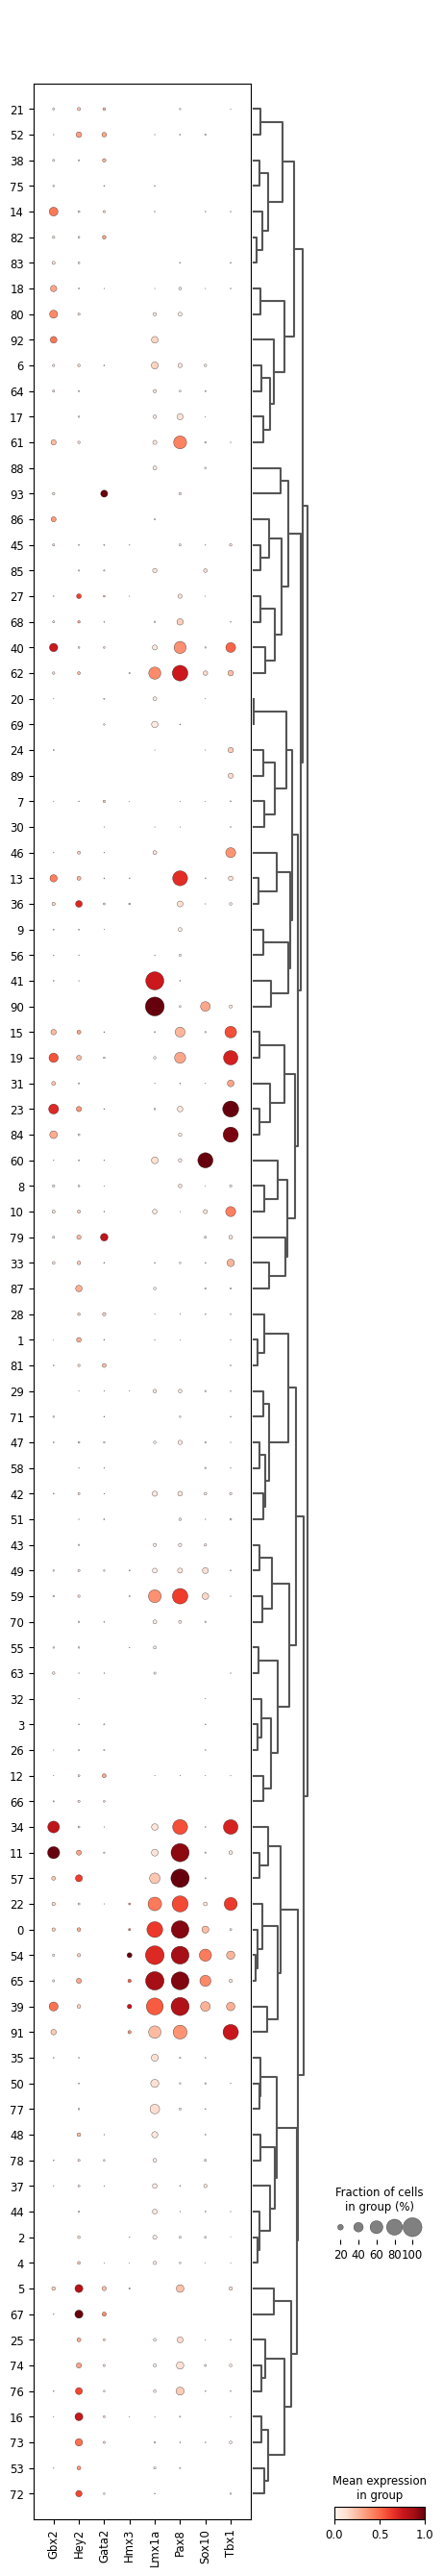

In [86]:
# Otic = '54', '39', '65'
sc.pl.rank_genes_groups_dotplot(
    adata_Epcam, groupby='leiden', standard_scale="var", var_names=placode_markers["Otic placode"])


In [8]:
def annotate_leiden_clusters_with_orig(adata, cluster_mapping, leiden_key='leiden', new_key='cluster_name'):
    import pandas as pd
    adata_copy = adata.copy()
    # Ensure leiden column is string
    adata_copy.obs[leiden_key] = adata_copy.obs[leiden_key].astype(str)

    # Build reverse mapping: cluster ID (string) → name
    cluster_to_name = {
        str(cluster): name
        for name, clusters in cluster_mapping.items()
        for cluster in clusters
    }

    # Apply mapping; fall back to original leiden ID if not in map
    adata_copy.obs[new_key] = adata_copy.obs[leiden_key].map(cluster_to_name)
    adata_copy.obs[new_key] = adata_copy.obs[new_key].fillna('other')

    # Convert to category
    adata_copy.obs[new_key] = adata_copy.obs[new_key].astype('category')
    return adata_copy



cluster_map = {
    'Epibranchial placode': ['11', '57'],
    'Otic placode': ['54', '65', '39', '0'],
    'Trigeminal placode': ['25', '74'],
    'Olfactory placode': ['2', '4', '37'],
    'Lens placode': ['35', '50', '77'],
    'Adenohypophyseal placode': ['46', '5']
}

adata_named = annotate_leiden_clusters_with_orig(adata_Epcam, cluster_map)

mapped_cluster_names = list(cluster_map.keys())

print(adata_named.obs['cluster_name'].unique())



['Epibranchial placode', 'other', 'Trigeminal placode', 'Otic placode', 'Olfactory placode', 'Lens placode', 'Adenohypophyseal placode']
Categories (7, object): ['Adenohypophyseal placode', 'Epibranchial placode', 'Lens placode', 'Olfactory placode', 'Otic placode', 'Trigeminal placode', 'other']


Text(0.5, 1.0, 'UMAP with placodal annotation')

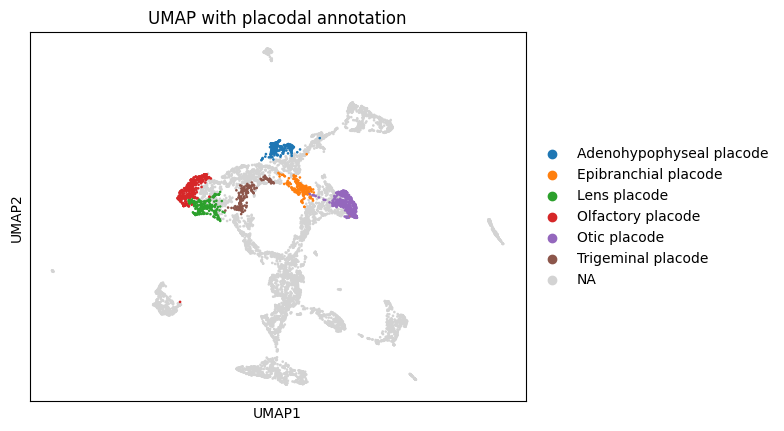

In [24]:
sc.pl.umap(adata_named, groups=['Adenohypophyseal placode', 'Otic placode', 'Lens placode', 'Trigeminal placode', 'Olfactory placode', 'Epibranchial placode'],  color=['cluster_name'], show=False)
plt.title('UMAP with placodal annotation')

In [24]:
adata_named.obs['cluster_name'].value_counts()

other                       6841
Otic placode                 450
Olfactory placode            420
Lens placode                 247
Epibranchial placode         206
Trigeminal placode           171
Adenohypophyseal placode      92
Name: cluster_name, dtype: int64

In [33]:
adata_named.write('single_cell_clustered.h5ad')

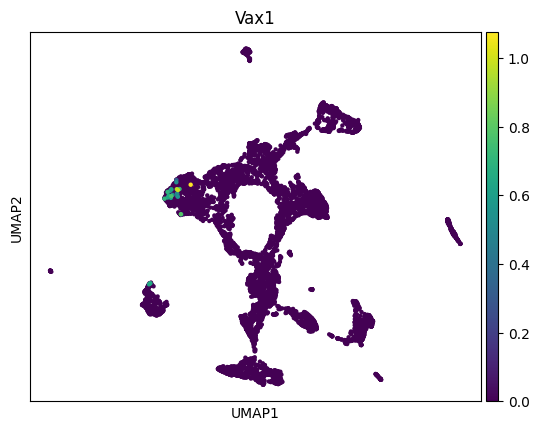

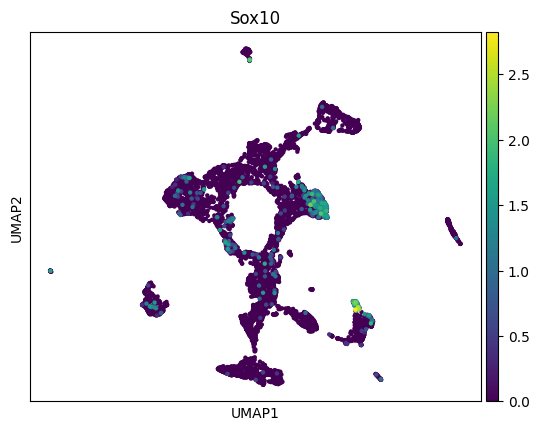

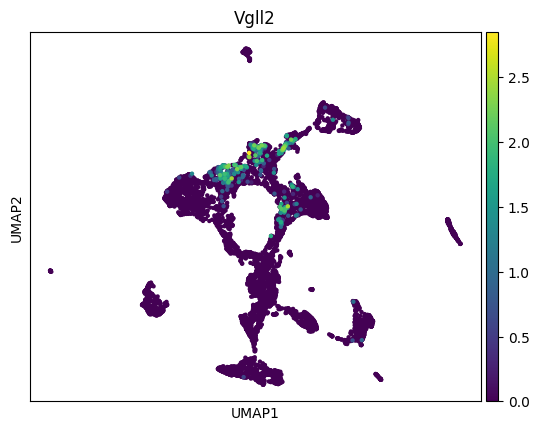

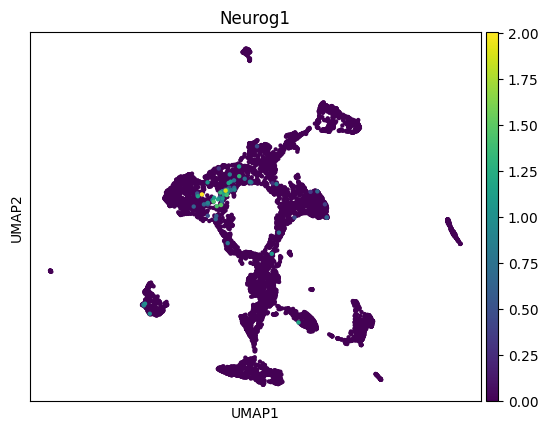

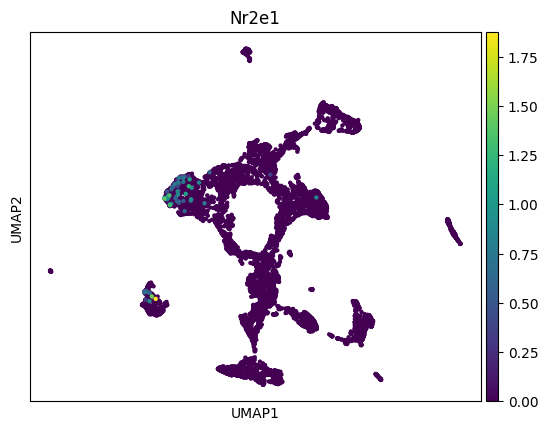

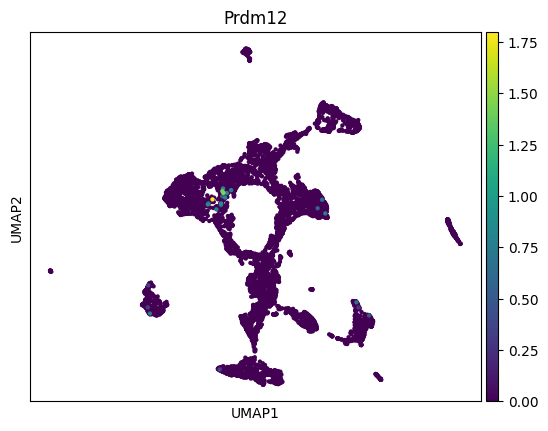

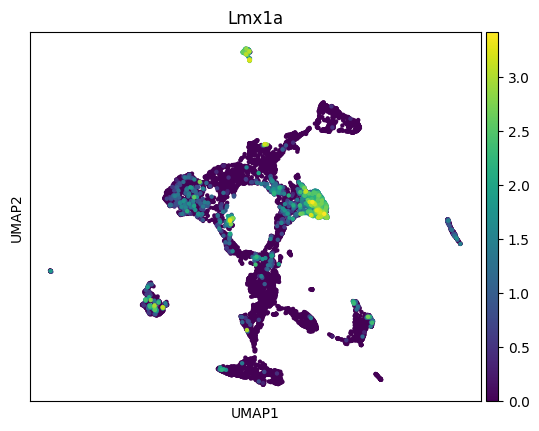

In [35]:
genes = ['Vax1', 'Sox10', 'Vgll2', 'Neurog1', 'Nr2e1', 'Prdm12', 'Lmx1a']
for gene in genes:
    sc.pl.umap(adata_named, color=[gene], size=40, save=f'{gene}_single_cell_umap.png')